# Homework 9: Introduction to Pytorch

name: Yiyang Zhang

email: zhyiyang@umich.edu

This homework assignment took me 35 hours in total to complete. (Please help us to gauge the difficulty of the assignment.)

## Collaboration Disclosure

In the cell below, please list *everyone* with whom you discussed any of the homework problems, excluding only the GSIs and the course instructor. 

If you did not discuss the homework with anyone else, write __"I did not discuss this homework with anyone."__

Even if you discuss questions with other, the code you submit must be only yours. All work is checked with the [MOSS plagiarism detector](https://theory.stanford.edu/~aiken/moss/).)

I discussed this homework with Wentao Xiong.

## Submission Instructions
Your homework solutions should be written entirely in this Jupyter notebook file. Once it contains your solutions, you should submit this notebook through Canvas. Before submitting, please make sure make sure __Cells->Run__ executes without errors; errors in your code cause problems for our auto-grader. Thus, even though we may ask you to check for errors in your functions, you should not include in your submission any examples of your functions actually raising those errors.

## Nbgrader

We will be using nbgrader to grade your jupyter notebook. Additional tests will be used at grading time, you are encouraged to read the problem carefully and verify your code covers all appropriate cases.

This homework has a higher maximum time limit per cell as compared to previous homework. Please check that each cell of your notebook takes less than __30 minutes__ to run. __Problem 1__ should be relatively fast (each cell should take < 2 minutes to run) and __Problem 2__ the training can take a bit longer but less than __30 minutes__.

## Error checking

You do not need to do error checking (raising errors, etc.) in your code unless we explicitly ask you to so in a problem.

## Coding style
Please follow the [PEP8 guidelines](https://www.python.org/dev/peps/pep-0008/). The `pycodestyle_magic` package will remind you if you are not. To install it, run
```
pip install flake8 pycodestyle_magic
```
Once it is installed the following two Jupyter directives will enable syntax checking:

In [1]:
%load_ext pycodestyle_magic
%flake8_on --ignore E266 --max_line_length 99

## Problem 1: Building and training simple models with Pytorch (15 points) 
In this problem, you'll use **Pytorch** to build the loss functions for a pair of commonly-used statistical models. 

We will use variables $X$ and $Y$, which will serve as the predictor (independent variable) and response (dependent variable), respectively. Please use $W$ to denote a parameter that multiplies the predictor, and $b$ to denote a bias parameter (i.e., a parameter that is added).

In [2]:
# You will probably need these imports
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from sklearn import datasets
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

### Part 1: Logistic regression (1 point)

In this model, which we discussed briefly in class, the binary variable $Y$ is distributed as a Bernoulli random variable with success parameter $\sigma(W^T X + b)$, where $\sigma(z) = (1+\exp(-z))^{-1}$ is the logistic function, $X \in R^6$ is the predictor random variable, and $W \in R^6, b \in R$ are the model parameters. 
 
Using **Pytorch** code, implement a class `LogisticRegression` that inherits from `nn.module`. This class should should have two attributes `w` and `b` which should be `nn.parameters` with shapes `(6,1)` and `(1)` respectivelly. 

This class should a method called `forward` that takes in the predictor random variable `x` with shape `(N, 6)`, where `N` is the number of observations, and returns the success parameter (also known as the prediction of our model on $Y$).

**Note:** Please initialize both `w, b` to be __all-one float tensors.__

In [3]:
class LogisticRegression(nn.Module):
    # YOUR CODE HERE
    # Begin answer
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.w = nn.Parameter(torch.ones([6, 1]))
        self.b = nn.Parameter(torch.ones(1))

    def forward(self, x):
        z = torch.mm(x, self.w)+self.b
        y = torch.reciprocal(1+torch.exp(-z))
        return y
    # End answer

In [4]:
model = LogisticRegression()
assert type(model.w) == nn.Parameter
assert type(model.b) == nn.Parameter
x = torch.eye(6).float()
y = model.forward(x)
assert y.shape == (6, 1)
assert 0.86 < model.forward(x)[0].item() < 0.90

### Part 2: Negative log-likelihood loss (1 point)

Using **Pytorch** code, write a function called `neg_log` that takes in `y_true` (true value of $Y$) and `y_pred` (predicted value of $Y$) and returns the negative log-likelihood loss function. You can assume that both `y_true` and `y_pred` have shapes `N x 1` where `N` is the number of observations. 
 
 __Hint:__ The loss should be a negative log-likelihood term, summed over all the observations. Remember that $Y$ is Bernoulli distributed which should suggest what the likelihood is. 

In [5]:
def neg_log(y_true, y_pred):
    # YOUR CODE HERE
    # Begin answer
    log_pred = torch.log(y_pred)
    m_log_pred = torch.log(1-y_pred)
    m_y_true = 1 - y_true
    loss = -(torch.mul(y_true, log_pred)+torch.mul(m_y_true, m_log_pred))
    loss_sum = torch.sum(loss)
    return loss_sum
    # End asnwer

In [6]:
y_true = torch.tensor([1, 1, 1, 1, 1]).float().view(5, 1)
y_pred = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5]).float().view(5, 1)
assert 3.4 < neg_log(y_true, y_pred).item() < 3.6

### Part 3: Estimating parameters in  logistic  regression (4 points) 

The four Numpy `.npy` files included along with the homework contain train and test data generated from a logistic model:

- `logistic_xtest.npy`: contains a 500-by-6 matrix whose rows are the independent variables (predictors) from the test set.
    
- `logistic_xtrain.npy`: contains a 2000-by-6 matrix whose rows are the independent variables (predictors) from the train set.
    
- `logistic_ytest.npy`: contains a binary 500-dimensional vector of dependent variables (responses) from the test set.
    
- `logistic_ytrain.npy`: contains a binary 2000-dimensional vector of dependent variables (responses) from the train set.
    
The $i$-th row of the matrix in `logistic_xtrain.npy` is the predictor for the response in the $i$-th entry of the vector in `logistic_ytrain.npy`, and analogously for the two test set files.

For this part you will obtain estimates of your `LogisticRegression` class model parameters $W$ and $b$ by minimizing the negative log-likelihood via gradient descent. 

We recommend writing a separate function `train_loop` that takes in `lg_model` (your model), `optimizer` (the optimizer) and `train_dl_log` (the train dataloader) and runs the training loop for a single epoch. The `train_loop` function should:
- Iterate through dataloader to load data
- Evaluate prediction loss on training pair
- Propagate loss in the optimizer 
- Return average loss over all pairs returned by the train dataloader (divide the total loss by `len(train_dl_log)`). 

After you have written the training loop function, you'll need to complete the following steps in the next cell:

- Load the training data.

- Create dataloaders for your training data, your dataloader should return `(x,y)` training pairs. You should specify `shuffle=True` and `batch_size=100` for its keyword arguments.

- Create a SGD optimizer with `lr=0.001` (learning rate).

- Runs the training loop for __500 epochs__. 
    
- Store the losses returned by each epoch of `train_loop` into a list called `losses`. 

   
__Note:__ We didn't discuss reading numpy data from files. To load the files, you can simply call `x_train = np.load('xtrain.npy')` to read the data into the variable `x_train`. `x_train` will be a Numpy array. You will then have to convert them to pytorch tensors.

In [7]:
def train_loop(lg_model, optimizer, train_dl_log):
    # YOUR CODE HERE
    # Begin answer
    loss = list()
    for i, (x, y) in enumerate(train_dl_log):
        y_predict = lg_model.forward(x)
        mse = neg_log(y, y_predict)
        mse.backward()
        loss.append(mse.item())
        optimizer.step()
        optimizer.zero_grad()
    return sum(loss)/len(train_dl_log)
    # End answer

In [8]:
# Load training data, run training, and create your list `losses` here.

# load training data
# YOUR CODE HERE
# Begin answer
logistic_xtrain = np.load("logistic_xtrain.npy")
logistic_ytrain = np.load("logistic_ytrain.npy")
# End answer

# prepare data loaders.
# YOUR CODE HERE
# Begin answer
x_train = torch.from_numpy(logistic_xtrain)
y_train = torch.from_numpy(logistic_ytrain)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=0)
# End answer

# prepare logistic regression model and optimizer
# YOUR CODE HERE
# Begin answer
lg_model = LogisticRegression()
optimizer = torch.optim.SGD(lg_model.parameters(), lr=0.001)
# End answer

# train the model
# YOUR CODE HERE
# Begin answer
num_epochs = 500
losses = list()
for epoch in range(num_epochs):
    loss = train_loop(lg_model.double(), optimizer, train_dl)
    losses.append(loss)
# End answer

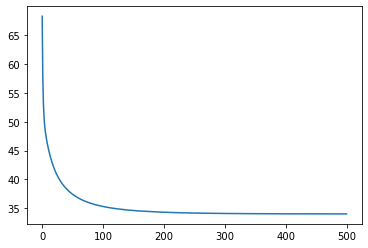

In [9]:
%matplotlib inline
# Check convergence of your loss here, 
plt.plot(losses)

In [10]:
assert losses[-1] < 40  # make sure your loss is low enough before continuing

In [11]:
b = lg_model.b.item()
assert b < 0

In [12]:
w = lg_model.w.detach().numpy()
assert w.shape == (6, 1)
w1 = w[0, 0].item()
assert 0.9 < w1 < 1.0

### Part 4: Evaluating your trained model (1 point)

Load the test data. What is the negative log-likelihood of your model on this test data? That is, what is the negative log-likelihood when you use your estimated parameters with the previously unseen test data? Store this value on a `float` variable `loss_test`.  Please use a `batch_size=500` and do not take an average, just sum the losses.

In [13]:
# Load test data and evaluate the loss of your trained model here.
# YOUR CODE HERE
# Begin answer
logistic_xtest = np.load("logistic_xtest.npy")
logistic_ytest = np.load("logistic_ytest.npy")
x_test = torch.from_numpy(logistic_xtest)
y_test = torch.from_numpy(logistic_ytest)
test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=500, shuffle=True, num_workers=0)

loss_test_lst = list()
for i, (x, y) in enumerate(test_dl):
    y_predict_test = lg_model.forward(x)
    mse = neg_log(y, y_predict_test)
    mse.backward()
    loss_test_lst.append(mse.item())
loss_test = sum(loss_test_lst)
# End answer

In [14]:
assert type(loss_test) == float

### Part 5 Evaluating the estimated logistic parameters (1 point) 

The data was, in reality, generated with 

$$ W = (1,1,2,3,5,8),~~~~~~ b = -1. $$
   
Write **Pytorch** expressions to compute the squared error between your estimated parameters and their true values. Store your results in variables `Wsqerr` and `bsqerr` respectively. 

__Note:__ you need only evaluate the error of your final estimates, not at every step.

In [15]:
# YOUR CODE HERE
# Begin answer
w = lg_model.w
b = lg_model.b
w_true = torch.tensor([[1.], [1.], [2.], [3.], [5.], [8.]], dtype=torch.float)
b_true = torch.tensor([-1.], dtype=torch.float)
mse_loss = nn.MSELoss()
Wsqerr = float(mse_loss(w, w_true))
bsqerr = float(mse_loss(b, b_true))
# End answer

In [16]:
assert type(Wsqerr) == float
assert type(bsqerr) == float
assert 0.0001 < bsqerr < 0.009

### Part 6  Classification  of  normally  distributed  data.  (4 points) 

There are four other `.npy` that are included with this homework. These files contain train and test data generated from $K=3$ different classes. Each class $k \in \{1,2,3\}$ has an associated mean $\mu_k \in R$ and variance $\sigma^2_k \in R$, and all observations from a given class are i.i.d. $\mathcal{N}(\mu_k,\sigma^2_k)$.

The four files are:

- `normal_xtest.npy`: contains a 500-vector whose entries are the independent variables (predictors) from the test set.

- `normal_xtrain.npy`: contains a 2000-vector whose entries are the independent variables (predictors) from the train set.

- `normal_ytest.npy`: contains a 500-by-3 dimensional matrix whose rows are one-hot encodings of the class labels for the test set.

- `normal_ytrain.npy`: contains a 2000-by-3 dimensional matrix whose rows are one-hot encodings of the class labels for the train set.
    
The $i$-th entry of the vector in `normal_xtrain.npy` is the observed random variable from class with label given by the $i$-th row of the matrix in `normal_ytrain.npy`, and analogously for the two test set files.

Load the training data and use it to obtain estimates of the vector of class means $\mu = (\mu_0,\mu_1,\mu_2)$ and variances $\sigma^2 = (\sigma^2_0, \sigma^2_1, \sigma^2_2)$ by minimizing the cross-entropy between the estimated normals and the one-hot encodings of the class labels (as we did in our softmax regression example in class). 

   
This time, instead of using gradient descent, use Adagrad, supplied by Pytorch as the function `torch.optim.Adagrad`. _Adagrad_ is a _stochastic gradient descent algorithm_, popular in machine learning. You can call this just like the gradient descent optimizer we used in class---just supply a learning rate. Documentation for the Pytorch implementation of Adagrad can be found here: https://pytorch.org/docs/stable/_modules/torch/optim/adagrad.html. See https://en.wikipedia.org/wiki/Stochastic_gradient_descent for more information about stochastic gradient descent and the Adagrad algorithm.

**Deliverables:** Create and name the corresponding variables `mu` and `sigma2`. As before, calculate the average loss in each epoch and return a list of `loss_norm` that can be used for plotting (averaged over the # of pairs returned by the dataloader, just like before). __Please make sure to do the following:__

- Initialize all mu's as all-zero tensors and the sigma2's as all-one tensors.

- Use `batch_size=100`

- Use a learning rate of __0.04__. 

- Run for __500__ epochs. 

	
__Note:__ you'll no longer be able to use the built-in logit cross-entropy that we used for training our models in lecture. Your cross-entropy for one observation should now look something like $ -\sum_k y'_k \log p_k,$ where $y'$ is the one-hot encoded vector and $p$ is the vector whose $k$-th entry is the (estimated) probability of the $k$-th observation given its class. 
   
__Another note:__ Do not include any estimation of the mixing coefficients (i.e., the class priors) in your model. You only need to estimate three means and three variances, because we are building a _discriminative_ model in this problem.

In [17]:
# Your code to create the model, load data, and train model goes here.

# YOUR CODE HERE
# Begin answer
import math
from torch.distributions import Normal
# Load Training Data
normal_x_train = np.load('normal_xtrain.npy')
normal_y_train = np.load('normal_ytrain.npy')
normal_x_train_tch = torch.from_numpy(normal_x_train)
normal_y_train_tch = torch.from_numpy(normal_y_train)
normal_train_ds = TensorDataset(normal_x_train_tch, normal_y_train_tch)
normal_train_dl = DataLoader(normal_train_ds, batch_size=100, shuffle=True, num_workers=0)


# Create Model
class NormalMeanVariance(nn.Module):
    def __init__(self):
        super(NormalMeanVariance, self).__init__()
        self.mu = nn.Parameter(torch.zeros(1, 3, dtype=torch.float))
        self.sigma2 = nn.Parameter(torch.ones(1, 3, dtype=torch.float))

    def forward(self, x):
        dist = Normal(self.mu, torch.sqrt(self.sigma2))
        y_predict = dist.log_prob(x)
        return y_predict


def cross_entropy(y_true, y_predict):
    result = torch.mul(y_true, y_predict)
    total = -torch.sum(result, dim=1)
    total_mean = torch.sum(total)/len(total)
    return total_mean


def train_loop_norm(norm_model, optimizer, train_dl_norm):
    loss = list()
    for i, (x, y) in enumerate(train_dl_norm):
        y_predict = norm_model.forward(x)
        mse = cross_entropy(y, y_predict)
        mse.backward()
        loss.append(mse.item())
        optimizer.step()
        optimizer.zero_grad()
    return sum(loss)/len(train_dl_norm)


# Train Model
normal_model = NormalMeanVariance()
optimizer_normal = torch.optim.Adagrad(normal_model.parameters(), lr=0.04)
num_epochs = 500
loss_norm = list()
for epoch in range(num_epochs):
    loss = train_loop_norm(normal_model, optimizer_normal, normal_train_dl)
    loss_norm.append(loss)

mu = normal_model.mu.detach()
sigma2 = normal_model.sigma2.detach()
# End answer

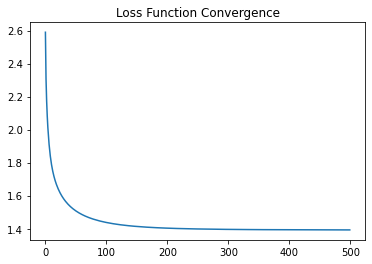

In [18]:
### Check convergence of your function.
plt.plot(loss_norm)
plt.title("Loss Function Convergence")
plt.show()

In [19]:
"""Check correctness of your final loss function."""
assert loss_norm[-1] < 150

In [20]:
assert type(mu) == torch.Tensor
assert mu.shape == (1, 3)
assert -1.3 < mu[0, 0].item() < -0.7

In [21]:
assert type(sigma2) == torch.Tensor
assert sigma2.shape == (1, 3)
assert sigma2[0, 0] < 0.55

### Part 7: Evaluating loss on test data (1 point) 
Load the test data. What is the cross-entropy of your model on this test data? That is, what is the cross-entropy when you use your estimated parameters with the previously unseen test data? Store your answer in a variable `loss_norm_test`. Please use a `batch_size=500` and do not take an average just sum the losses.

In [22]:
# YOUR CODE HERE
# Begin Answer
# Load test data
normal_x_test = np.load('normal_xtest.npy')
normal_y_test = np.load('normal_ytest.npy')
norm_x_test_tch = torch.from_numpy(normal_x_test)
norm_y_test_tch = torch.from_numpy(normal_y_test)
norm_test_ds = TensorDataset(norm_x_test_tch, norm_y_test_tch)
norm_test_dl = DataLoader(norm_test_ds, batch_size=500, shuffle=True, num_workers=0)

# Evaluation
loss_norm_test_lst = list()
for i, (x, y) in enumerate(norm_test_dl):
    norm_y_predict_test = normal_model.forward(x)
    mse = cross_entropy(y, norm_y_predict_test)
    mse.backward()
    loss_norm_test_lst.append(mse.item())
loss_norm_test = sum(loss_norm_test_lst)

In [23]:
assert type(loss_norm_test) == float
assert loss_norm_test < 800

### Part 8: Evaluating parameter estimation on test data (1 point) 

The true parameter values for the three classes were

\begin{equation*} \begin{aligned}
\mu_0 &= -1, \sigma_0^2 = 0.5 \\
\mu_1 &= 0, \sigma_1^2 = 1 \\
\mu_2 &= 3, \sigma_2^2 = 1.5.
\end{aligned} 
\end{equation*}

Write a **Pytorch** expression to compute the total squared error (i.e., summed over the six parameters) between your estimates and their true values. What is the squared error? Stored it in a variable `squared_error`. 

__Note:__ you need only evaluate the error of your final estimates, not at every step.

In [24]:
# YOUR CODE HERE
# Begin Answer
mu = normal_model.mu
sigma2 = normal_model.sigma2
mu_true = torch.tensor([[-1., 0., 3.]], dtype=torch.float)
sigma2_true = torch.tensor([[0.5, 1.0, 1.5]], dtype=torch.float)
mse_loss = nn.MSELoss()
MUsqerr = float(mse_loss(mu, mu_true))
SIGMAsqerr = float(mse_loss(sigma2, sigma2_true))
squared_error = MUsqerr + SIGMAsqerr
# End answer

In [25]:
assert type(squared_error) == float
assert squared_error < 0.030

### Part 9: Evaluating classification error on test data. (1 point)

Write and evaluate a **Pytorch** expression that computes the classification error of your estimated model averaged over the test data. Store your answer in a variable `error`. The classification error is the number of incorrectly predicted samples divided by the total number of samples. The predicted value is the argmax of the vector of log probabilities.

In [26]:
# YOUR CODE HERE
normal_predicted_value = normal_model.forward(norm_x_test_tch)
normal_predicted_argmax = torch.argmax(normal_predicted_value, dim=1)
normal_actural_argmax = torch.argmax(norm_y_test_tch, dim=1)
error = 1-torch.sum(normal_predicted_argmax ==
                    normal_actural_argmax).item()/len(normal_predicted_value)

In [27]:
assert type(error) == float
assert error < 0.40

## Problem 2 (15 points) 

Modify the Multilayer Perceptron implementation below to achieve a better performance. In particular,
- Your Validation and Test set accuracies should be >= 92%
- Answer the questions at the bottom of this notebook

Please read and execute this notebook first to make sure everything works correctly. Then, make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

### PIL
Note that Python's Imaging Library (PIL) can be installed via

    pip install pillow
    
### matplotlib 
Make sure that you have the latest version of matplotlib installed via 

    pip install matplotlib --upgrade
    
there is a bug in older versions that might cause an error during training. 

### Credit
This problem is based on a homework assignment written by Sebastian Raschka (sraschka@wisc.edu)
The dataset is from him too. Please do not distribute this modified version of his work.

In [28]:
import torch
import os
import pandas as pd
import numpy as np
import time
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [29]:

# if you suspect the initialization is off, you could try to change the random seed.
RANDOM_SEED = 123

# If there is a GPU available, it will use it,
# otherwise, it will use the CPU
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Note:** I actually noticed that this code runs faster on the CPU than on the GPU, because the dataset is so small. However, you are encouraged to try out training on a GPU if you are interested, e.g., via Google Colab.

### Loading test
The dataset consists of 3 classes:
- Drawings of "birds" (class 0)
- Drawings of "pizzas" (class 1)
- Drawings of "screwdrivers" (class 2)

(The dataset is based on Google Quickdraw: I wrote a script to fetch the images from the database here: https://quickdraw.withgoogle.com/data)

The dataset is very small on purpose so that the training should be relatively fast (but this wouldn't be an ideal DL dataset because of its small size).

In [30]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))

Class distribution Train [8005 7669 6826]


The images are 28x28 dimensional (grayscale).

Some examples:

png_files\bird_000043.png


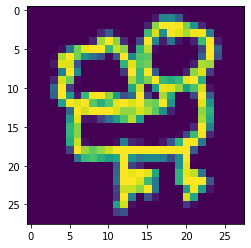

png_files\bird_000107.png


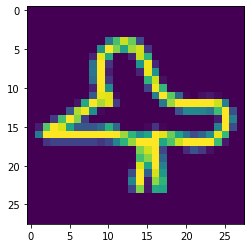

png_files\pizza_000000.png


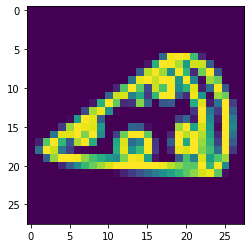

png_files\pizza_000002.png


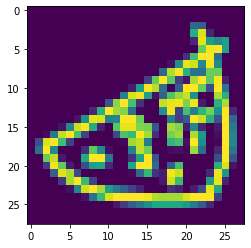

png_files\screwdriver_000001.png


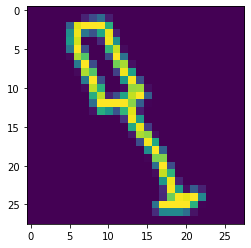

png_files\screwdriver_000012.png


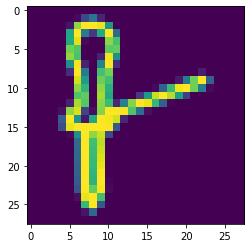

In [31]:
%matplotlib inline
import glob
for i in (12, 25, 30000, 30001, 60000, 60005): 
    image_paths = sorted(glob.glob('png_files/*.png'))
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    plt.close()

### Setup dataset and dataloaders

- The only thing you should change in this section during experimenting is the batch size
- However, it is not necessary to make changes to the batch size for your solution to work. 

In [32]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                         self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [33]:
# CHANGE IF YOU LIKE, keep variable name the same.
# NOTE: Using more workers might help make training faster. It depends on your computer.
# feel free to experiment and see what works.
BATCH_SIZE = 200
N_WORKERS = 0

In [34]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
custom_transform = transforms.Compose([transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='png_files/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=N_WORKERS)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='png_files/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='png_files/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS)

The cell below just checks if the dataset can be loaded correctly.

In [35]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 200
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 200
break minibatch for-loop


If you get an error, make sure the `png_files` directory is in the same directory as this notebook.

### Multilayer Perceptron Model (You need to make changes in this section)

The cell below contains the multi-layer perceptron model. **This is the main section where you want to make changes to the architecture.**

In [36]:
class MLP(torch.nn.Module):

    def __init__(self, num_features,
                 num_hidden_1,
                 num_hidden_2,
                 num_hidden_3,
                 num_hidden_4,
                 num_classes):
        super(MLP, self).__init__()

        self.num_classes = num_classes

        # ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
        self.linear_4 = torch.nn.Linear(num_hidden_3, num_hidden_4)
        self.linear_out = torch.nn.Linear(num_hidden_4, num_classes)

    def forward(self, x):
        # MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        # ANYTHNG IN THE __init__ METHOD ABOVE
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out)
        out = F.relu(out)
        out = self.linear_4(out)
        out = F.relu(out)

        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas


# Model Initialization
# You should keep the variable names 'model' and 'optimizer' created below.


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
torch.manual_seed(RANDOM_SEED)

# IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU
# ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
# added a second hidden layer, you may want to add a
# hidden_2 parameter here. Also you may want to play
# with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=100,
            num_hidden_2=100,
            num_hidden_3=100,
            num_hidden_4=100,
            num_classes=4)

model = model.to(DEVICE)


# For this homework, do not change the optimizer. However, you
# likely want to experiment with the learning rate.
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [37]:
"""You can ignore this cell."""
# YOUR CODE HERE

'You can ignore this cell.'

### Training

In [38]:
# DO NOT make changes to this cell

def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


start_time = time.time()
minibatch_cost = []
epoch_cost = []

__No need to change anything below, However, you can change the number of epochs if you like.__

In [39]:
NUM_EPOCHS = 20  # You can change if you like. Do not set it larger than 80.

In [40]:
# DO NOT make changes.
def run_training():
    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)

            # FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()
            cost.backward()
            minibatch_cost.append(cost)

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 50:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                      % (epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), cost))

        model.eval()
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)

        train_accuracy = compute_accuracy(model, train_loader)
        valid_accuracy = compute_accuracy(model, valid_loader)

        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, NUM_EPOCHS, cost))
        print('Train Accuracy: %.3f | Validation Accuracy: %.3f'
              % (train_accuracy, valid_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return train_accuracy, valid_accuracy

### Evaluation (Make no changes in this section)

In [41]:
# DO NOT make changes.
def evaluation():
    plt.plot(range(len(minibatch_cost)), minibatch_cost)
    plt.ylabel('Cross Entropy')
    plt.xlabel('Minibatch')
    plt.show()

    plt.plot(range(len(epoch_cost)), epoch_cost)
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epoch')
    plt.show()

    test_accuracy = compute_accuracy(model, test_loader)

    print('Test Accuracy: %.2f' % test_accuracy)
    return test_accuracy

### Conclusions (YOUR ANSWERS REQUIRED)

#### Question 1 ( 10 points) 
In this part we will check that your training/validation/testing accuracies are correct. As stated at the beginning of the problem, for full credit your validation and test accuracy must be >= 92%. If you can not achieve >= 92% accuracy, partial credit will be given for accuracy >= 90%.

To answer this question, please do the following:
1. Train and evaluate your network using the commands in the cell below. 
2. When you are satisfied with the performance of your network and are ready to submit your assignment, __comment out all lines of code in the cell below__.
3. Paste your train, validation, and test accuracies in the appropriate cell. __These accuracies should correspond to the exact architecture, number of epochs, and learning rate that you have in your submitted notebook__.

**Note:** The autograder will not automatically run your fitted model; we will be relying on the self-reported accuracies to grade your submission. However, we will randomly select some submissions to confirm accuracy, and if there is a significant discrepancy between the computed accuracy and your reported accuracy, you will receive 0 points for this part.

Epoch: 001/020 | Batch 000/113 | Cost: 1.3598
Epoch: 001/020 | Batch 050/113 | Cost: 1.2104
Epoch: 001/020 | Batch 100/113 | Cost: 1.0528
Epoch: 001/020 Train Cost: 1.0020
Train Accuracy: 44.013 | Validation Accuracy: 44.960
Time elapsed: 0.58 min
Epoch: 002/020 | Batch 000/113 | Cost: 1.0179
Epoch: 002/020 | Batch 050/113 | Cost: 0.7239
Epoch: 002/020 | Batch 100/113 | Cost: 0.5887
Epoch: 002/020 Train Cost: 0.5660
Train Accuracy: 81.182 | Validation Accuracy: 81.560
Time elapsed: 1.05 min
Epoch: 003/020 | Batch 000/113 | Cost: 0.5441
Epoch: 003/020 | Batch 050/113 | Cost: 0.4669
Epoch: 003/020 | Batch 100/113 | Cost: 0.3633
Epoch: 003/020 Train Cost: 0.4335
Train Accuracy: 84.480 | Validation Accuracy: 84.640
Time elapsed: 1.53 min
Epoch: 004/020 | Batch 000/113 | Cost: 0.4657
Epoch: 004/020 | Batch 050/113 | Cost: 0.4558
Epoch: 004/020 | Batch 100/113 | Cost: 0.4215
Epoch: 004/020 Train Cost: 0.3707
Train Accuracy: 87.169 | Validation Accuracy: 87.160
Time elapsed: 2.00 min
Epoch: 0

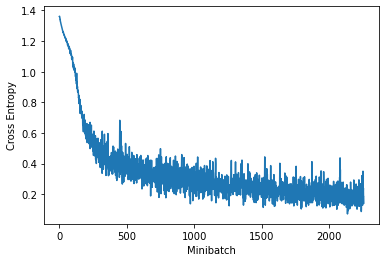

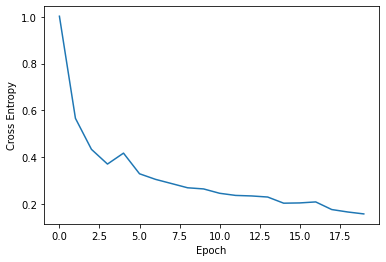

Test Accuracy: 92.28
train accuracy:  tensor(95.3200, device='cuda:0')
valid accuracy:  tensor(92.4400, device='cuda:0')
test accuracy:  tensor(92.2769, device='cuda:0')


In [42]:
# COMMENT OUT THESE LINES AFTER YOU HAVE FINISHED TRAINING YOUR NETWORK
train_accuracy, valid_accuracy = run_training()
test_accuracy = evaluation()
print("train accuracy: ", train_accuracy)
print("valid accuracy: ", valid_accuracy)
print("test accuracy: ", test_accuracy)

Paste the train, validation, and test accuracies (the output of the previous cell) into the cell below. __If you do not paste the accuracies, you will receive no credit for this part.__

Train Accuracy: 95.3200

Valid Accuracy: 92.4400

Test Accuracy: 92.2769

In [43]:
assert NUM_EPOCHS <= 80

#### Question 2 (2 points)

Do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?

Yes, there is some overfitting.

Because from the three accuracies we got above, we can see that the train accuracy is higher than valid accuracy and test accuracy. It means that the model learns the detail and noise in the training data. So, it negatively impacts the performance of the model on test data.

Reduce the complexity of the model by reducing the perceptrons in each layer and reducing the layers.

#### Question 3 (3 points)
What architectual changes did you make to improve the performance? Briefly list them below.

Increase the number of the hidden layers and the number of the perceptrons in each layer.